###### Let's Dive in!

In [1]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm
!pip install -U fastai
import timm
!pip install --upgrade fastcore fastai
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1982.2 MB 7.0 MB/s eta 0:00:0101    |███████████████▏                | 942.6 MB 3.4 MB/s eta 0:05:05     |███████████████▉                | 977.7 MB 2.9 MB/s eta 0:05:45| 1008.4 MB 70.4 MB/s eta 0:00:14 | 1171.3 MB 68.8 MB/s eta 0:00:12     |████████████████████████        | 1483.3 MB 62.0 MB/s eta 0:00:09     |███████████████████████████▌    | 1703.4 MB 81.7 MB/s eta 0:00:04�█▍ | 1881.1 MB 573 kB/s eta 0:02:57
     |████████████████████████████████| 17.6 MB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 20.9 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0a0+340c412
    Uninstalling torch-1.13.0a0+340c412:
      Successfully uninstalled torch-1.13.0a0+340c412
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d382986ab0eb1c3e18f39609cb4893fcfccbb3f7fff0bade349e8e536163f784
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnxc1a8e/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


###### Import the necessary libraries

In [2]:
import random # just as the name implies, it's used for randomness
import numpy as np #numpy is numpy.......manages arrays
import gc #This is the garbage collector, I doubt we'll use it. i'm using colab pro
from pathlib import Path #path library manages path
import matplotlib.pyplot as plt #to plot basically
import pandas as pd #key library to manage your dataframe.
# from efficientnet_pytorch import EfficientNet #The model we're intrested in.
import torch

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

In [4]:
df = pd.read_csv("train.csv")
df = df.drop(['center_id', 'patient_id', 'image_num'], axis = 1)
df = df[df['image_id'] != '6baf51_0']
df = df[df['image_id'] != 'b894f4_0']

class_0,class_1=df['label'].value_counts()

df_class_0=df[df['label']=='CE']
df_class_1=df[df['label']=='LAA']

df_class_0_under=df_class_0.sample(class_1)

df=pd.concat([df_class_0_under,df_class_1],axis=0)

# test_df = pd.read_csv("/content/drive/MyDrive/machine_learning_stories/Hand_sign/Test.csv")
# ss = pd.read_csv("/content/drive/MyDrive/machine_learning_stories/Hand_sign/SampleSubmission.csv")

In [5]:
a = df['image_id']
a = a.tolist()

###### Setup your dataframe.
These are basic stuff, just load in your dataframe with the pandas library

In [6]:
train_df = pd.read_csv("new_train.csv")
b = train_df.image_id
b = b.tolist()
c = []
d = []
for i in b:
    for j in a:
        if i[:-2] == j:
            c.append(i)
            d.append(df[df['image_id'] == j].iloc[0]['label'])

In [7]:
len(c), len(a), len(b)

(2622, 412, 6812)

In [8]:
# train_df = pd.read_csv("new_train.csv")
# train_df = train_df.drop(['center_id', 'image_num', 'patient_id'], axis = 1)
# train_df = train_df[train_df['image_id'] != '6baf51_0']
# train_df = train_df[train_df['image_id'] != 'b894f4_0']

train_df = pd.DataFrame(list(zip(c, d)),
               columns =['image_id', 'label'])
# class_0,class_1=train_df['label'].value_counts()

# df_class_0=train_df[train_df['label']=='CE']
# df_class_1=train_df[train_df['label']=='LAA']

# df_class_0_under=df_class_0.sample(class_1)

# train_df=pd.concat([df_class_0_under,df_class_1],axis=0)

# test_df = pd.read_csv("/content/drive/MyDrive/machine_learning_stories/Hand_sign/Test.csv")
# ss = pd.read_csv("/content/drive/MyDrive/machine_learning_stories/Hand_sign/SampleSubmission.csv")

Take a peak at your Dataframe.

In [9]:
train_df.tail()

,image_id,label
2617,ffec5c_0_5,LAA
2618,ffec5c_1_0,LAA
2619,ffec5c_1_1,LAA
2620,ffec5c_1_2,LAA
2621,ffec5c_1_3,LAA


Import FastAI. Kindly check out your version to avoid disparities. As at the time of writing mine was 2.5.3 as long as you are not using version 1.x.x we should be good.

In [10]:
import fastai
print(fastai.__version__ )

2.7.9


###### Import everthing from Fastai Vision...........Please note that it's a bad idea to import everything during model deployment.

In [11]:
from fastai.vision.all import * #import everthing from vision

###### Set Seed.

We def don't want to be in the shoes of those not able to reproduce their score, so let's seed everything seedable....

In [12]:
 def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

In [13]:
random_seed(2022,True)

###### peak at your dataframe

In [14]:
train_df.head()

,image_id,label
0,008e5c_0_0,CE
1,008e5c_0_1,CE
2,00c058_0_0,LAA
3,00c058_0_1,LAA
4,00c058_0_2,LAA


I'm just simply appending the paths in front of the file name and ".jpg" as a suffix so that the image ids column can contain paths to the image. There are better ways of doing this though......you could even do all this in your data loader......✌

In [15]:
train_df.image_id    = ["stain_train/"+i+".png" for i in train_df.image_id]

peak again at new dataframe

In [16]:
train_df.head()

,image_id,label
0,stain_train/008e5c_0_0.png,CE
1,stain_train/008e5c_0_1.png,CE
2,stain_train/00c058_0_0.png,LAA
3,stain_train/00c058_0_1.png,LAA
4,stain_train/00c058_0_2.png,LAA


check your label distribution.

In [17]:
train_df.label.value_counts()

LAA    1347
CE     1275
Name: label, dtype: int64

In [18]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 14.0 MB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 208 kB 94.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 60.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 54.1 MB/s eta 0:00:01


In [77]:
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage import img_as_ubyte
import cv2

def hed_trans(patch):
    ycrcb_img = cv2.cvtColor(np.ascontiguousarray(patch), cv2.COLOR_BGR2YCrCb)

    # equalize the histogram of the Y channel
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

    # convert back to RGB color-space from YCrCb
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    ihc_hed = rgb2hed(equalized_img)
    # Rescale hematoxylin and DAB channels and give them a fluorescence look
    null = np.zeros_like(ihc_hed[:, :, 0])
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 0], 95)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 2], 95)))

    # Cast the two channels into an RGB image, as the blue and green channels
    # respectively
    zdh = img_as_ubyte(np.dstack((null, d, h)))
    return PILImage.create(zdh)

class hedtfm(Transform):
    def __init__(self, aug):
        self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(img)
        return aug_img
    
hed_tfms = hedtfm(hed_trans)

In [78]:
hand = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    splitter=TrainTestSplitter(0.05, stratify=train_df["label"]),
  get_x = ColReader(0),
  item_tfms=[Resize((512, 512), method='squish'), hed_tfms],  #Extra tip, use size that's suitable for the efficentNetwork you are using.
    get_y=ColReader(1),
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    )

Use the DataBlock to create your dataloader

In [79]:
dls = hand.dataloaders(train_df, bs=4, num_workers = 2)

Check out one batch

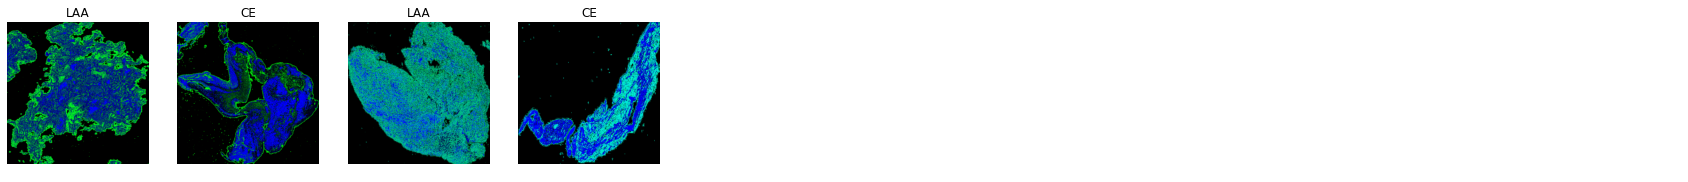

In [80]:
dls.show_batch(max_n=10, nrows=1, ncols=10)

define the function to help pull the model and set output to number of classes - see Luke's github repo for more

In [81]:
def get_model(dls,pretrained=True, **kwargs):
    
#     model = EfficientNet.from_pretrained(model_name)
#     model._fc = nn.Linear(model._fc.in_features, dls.c)
    
#     model = timm.create_model('convnext_large_384_in22ft1k', pretrained = True, num_classes = 2)
#       model = timm.create_model('xcit_large_24_p8_384_dist', pretrained = True, num_classes = 2)
    model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
    model.classifier.fc = nn.Linear(model.classifier.fc.in_features, dls.c)
#     model = torch.jit.load('model.pth')
    return model

Choose your model, you can choose any of the efficient net series b0 to b7

In [39]:
model_name = 'efficientnet-b7' #I'll use B5 here.

Define the learner params through Fastai.

In [82]:
learn = Learner(dls, get_model(dls), metrics=[error_rate, accuracy],).to_fp16()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


check out what changing the learning rate looks like.

SuggestedLRs(valley=0.05754399299621582)

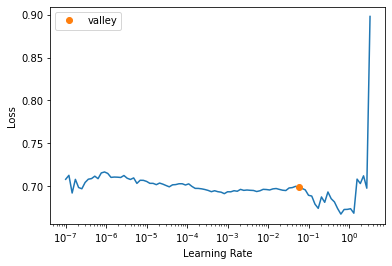

In [83]:
# learn.load('model1')
learn.lr_find()

###### Time to Train!!!

I'm using the valid loss callback to ensure I get the best local model.

In [84]:
learn.fine_tune(10, cbs= SaveModelCallback(monitor='valid_loss'))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.687698,0.680702,0.439394,0.560606,02:59


Better model found at epoch 0 with valid_loss value: 0.6807016730308533.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.681005,0.681837,0.416667,0.583333,02:55
1,0.678959,0.677943,0.424242,0.575758,02:55
2,0.669832,0.676400,0.439394,0.560606,02:56
3,0.658586,0.671638,0.439394,0.560606,03:00
4,0.646822,0.665013,0.431818,0.568182,02:57
5,0.636812,0.666445,0.401515,0.598485,03:01
6,0.626122,0.667149,0.386364,0.613636,03:00
7,0.604439,0.664619,0.401515,0.598485,02:59
8,0.613525,0.667311,0.401515,0.598485,02:56
9,0.601625,0.665040,0.393939,0.606061,02:57


Better model found at epoch 0 with valid_loss value: 0.6818374395370483.
Better model found at epoch 1 with valid_loss value: 0.6779431104660034.
Better model found at epoch 2 with valid_loss value: 0.6764004826545715.
Better model found at epoch 3 with valid_loss value: 0.6716381907463074.
Better model found at epoch 4 with valid_loss value: 0.6650127172470093.
Better model found at epoch 7 with valid_loss value: 0.6646194458007812.


/opt/conda/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.631675,0.676590,0.431818,0.568182,03:01


Better model found at epoch 0 with valid_loss value: 0.6765901446342468.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.585970,0.658751,0.363636,0.636364,03:01
1,0.576478,0.654190,0.356061,0.643939,02:58
2,0.572652,0.656409,0.356061,0.643939,03:02
3,0.563381,0.681267,0.371212,0.628788,02:56
4,0.537888,0.689109,0.409091,0.590909,02:57
5,0.475605,0.694460,0.340909,0.659091,02:57
6,0.475876,0.688964,0.378788,0.621212,02:58
7,0.482547,0.759209,0.401515,0.598485,02:54
8,0.419357,0.715598,0.401515,0.598485,02:56
9,0.404451,0.774326,0.401515,0.598485,02:56


Better model found at epoch 0 with valid_loss value: 0.6587506532669067.
Better model found at epoch 1 with valid_loss value: 0.6541903018951416.


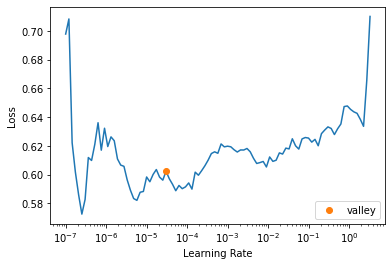

In [85]:
learn.load('model')
learn.lr_find()
learn.fine_tune(20, cbs= SaveModelCallback(monitor='valid_loss'))

Done Training!

###### Prepare for Predictions

I also need to change the filename to path so that the dataloader can load it in smoothly.

In [38]:
learn.load('model1')
learn.save('model1', with_opt = False)

Path('models/model1.pth')

In [31]:
test_df.img_IDS = ["/content/Images/"+i+".jpg" for i in test_df.img_IDS]

Check out what the head looks like

In [32]:
test_df.head()

,img_IDS
0,/content/Images/ImageID_USRB8QNG.jpg
1,/content/Images/ImageID_SZ8D1ZJI.jpg
2,/content/Images/ImageID_4OJO2F8J.jpg
3,/content/Images/ImageID_IEE4XV0B.jpg
4,/content/Images/ImageID_BP0O0WZ9.jpg


#### Trick 04: Who says you need to stop TTA at default?

As a pro, I assume you already use TTA. But do go all out on the Test Time Augumentation or just stick to Jeremy's defaults, here I used 15, This means that the dataloader auguments the test image in 15 different ways, performs inference and then averages it. Note that you can also pass in the "use_max" method if you want the maximum result of the 15 predictions. But using max

In [33]:
tdl = learn.dls.test_dl(test_df["img_IDS"]) # quicly create test data loader
test_preds_tta, test_labels_tta = learn.tta(dl=tdl, n=15) #TTA

###### Make your Submission!